In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import pprint
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 6 columns):
text          10876 non-null object
choose_one    10876 non-null object
tidy_tweet    10876 non-null object
polarity      10876 non-null float64
review_len    10876 non-null int64
word_count    10876 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.9+ KB


In [4]:
df.head()

,text,choose_one,tidy_tweet,polarity,review_len,word_count
0,Just happened a terrible car crash,Relevant,just happened a terrible car crash,-1.00,34,6
1,Our Deeds are the Reason of this #earthquake M...,Relevant,our deeds are the reason of this earthquake m...,0.00,69,13
2,"Heard about #earthquake is different cities, s...",Relevant,heard about earthquake is different cities s...,0.25,64,9
3,"there is a forest fire at spot pond, geese are...",Relevant,there is a forest fire at spot pond geese are...,0.00,96,19
4,Forest fire near La Ronge Sask. Canada,Relevant,forest fire near la ronge sask canada,0.10,38,7


In [5]:
# Helper function to get top-words

def get_top_words(model, feature_names, n_top_words):
    words = []
    for index, topic in enumerate(model.components_):
        words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
    return words

In [6]:
# Helper function to print top-words

def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [7]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The stemmed form of leaves is: {}".format(lemm.lemmatize("news")))

The stemmed form of leaves is: news


In [8]:
# Extending the CountVectorizer with a lemmatizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [9]:
# Storing entire training text in a list
text = list(df.tidy_tweet.values)

# Calling LemmaCountVectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [10]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

data = [go.Bar(
    x = x[0:50],
    y = y[0:50],
    marker = dict(colorscale='Jet', color = y[:50]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Top 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [11]:
data = [go.Bar(
    x = x[-50:],
    y = y[-50:],
    marker = dict(colorscale='Jet', color = y[-50:]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Bottom 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [12]:
n_topics = 8

In [13]:
# Implementing Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=15, learning_method='online', learning_offset=50, random_state=42)

In [14]:
lda_matrix = lda.fit_transform(tf)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=15, mean_change_tol=0.001,
             n_components=8, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [16]:
lda_keys = get_keys(lda_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [17]:
n_top_words = 20
print("\n Topics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


 Topics in LDA model: 

Topic #0police killed wildfire ve gt california know attack black body terrorist post report latest way wounded said injured update coming

Topic #1year life people building train old amp help lol thing burning fatal really live army plan run hit city game

Topic #2suicide make let bomber hostage typhoon 11 kill story severe hope amp earthquake saudi food survivor doe week mosque time

Topic #3news home dead collapse school great legionnaire damage red rt water landslide market stock bus breaking thunderstorm china outbreak crash

Topic #4storm time did photo hot fear work 2015 migrant smoke injury face right head traumatised boat scream rescuer hundred zone

Topic #5new emergency say world service house forest watch war wild woman siren reddit body stop read oil flame bag spill

Topic #6like don family car look bomb just hiroshima good ll people mh370 come god fire man feel pm mass going

Topic #7just amp video disaster nuclear got need love day flood obama we

In [18]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [19]:
first_topic.shape

(7101,)

In [20]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

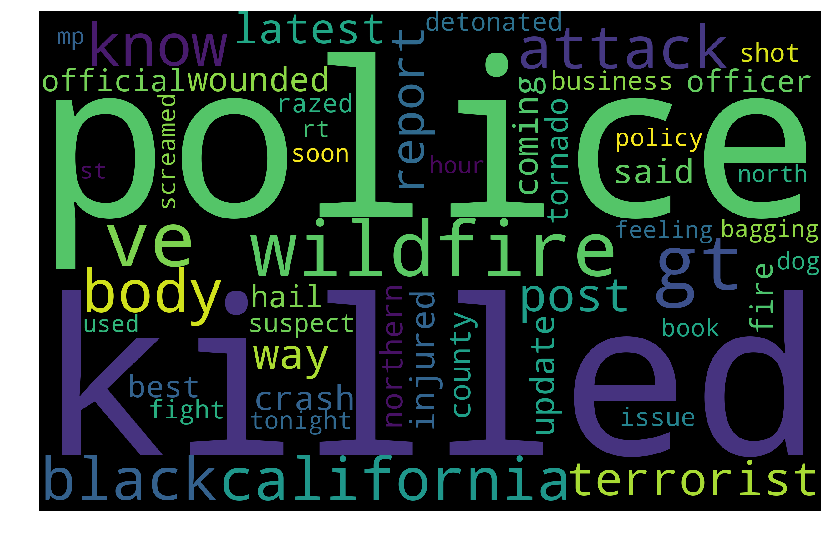

In [21]:
# Wordcloud of first topic
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(first_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

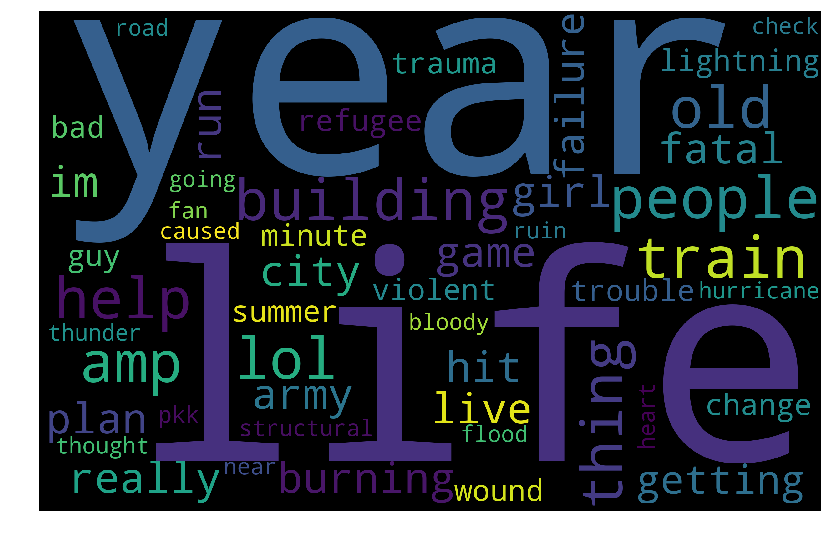

In [22]:
# Wordcloud of second topic
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(second_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

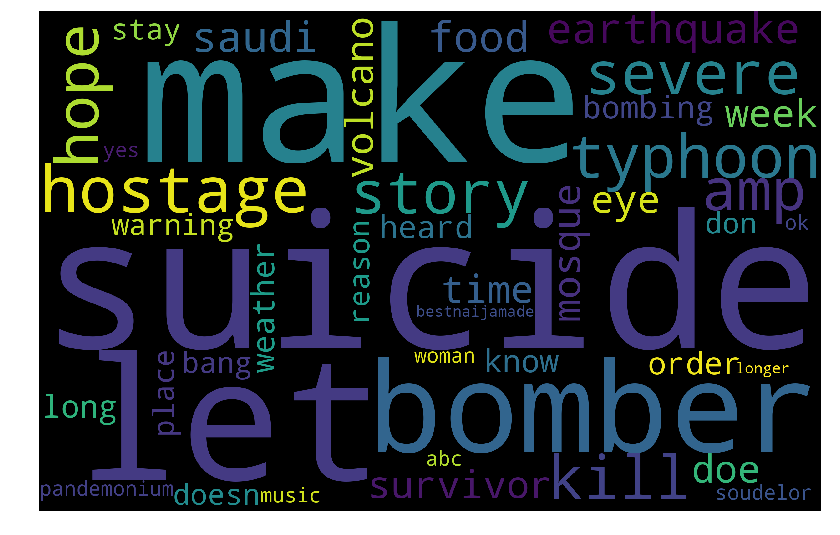

In [23]:
# Wordcloud of third topic
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(third_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

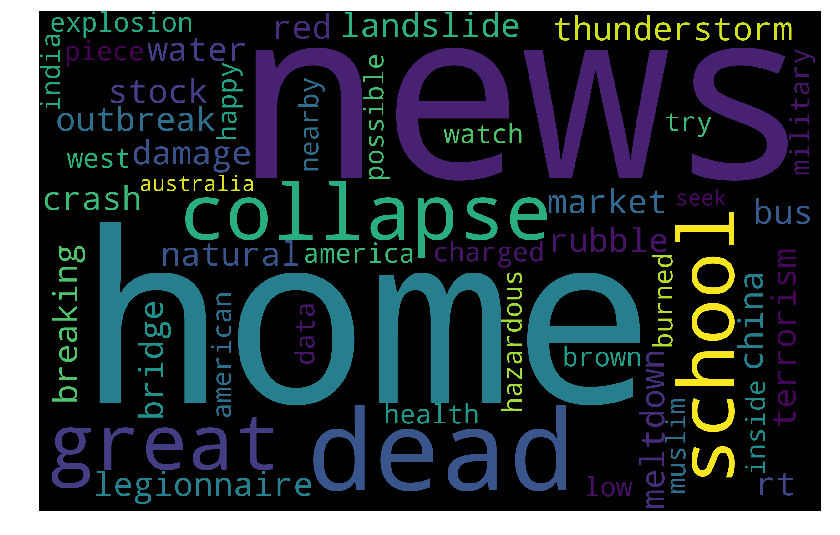

In [24]:
# Wordcloud of fourth topic
fourthcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(fourth_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

In [25]:
top_3_words = get_top_words(lda, tf_feature_names, 3)

In [26]:
top_3_words[0]

['police', 'killed', 'wildfire']

In [27]:
lda_categories

[6, 2, 5, 1, 4, 0, 7, 3]

In [28]:
labels = ['Topic {}: {}'.format(i, ' '.join(top_3_words[i])) for i in lda_categories]

In [29]:
labels

['Topic 6: like don family',
 'Topic 2: suicide make let',
 'Topic 5: new emergency say',
 'Topic 1: year life people',
 'Topic 4: storm time did',
 'Topic 0: police killed wildfire',
 'Topic 7: just amp video',
 'Topic 3: news home dead']

Text(0.5,1,'LDA topic counts')

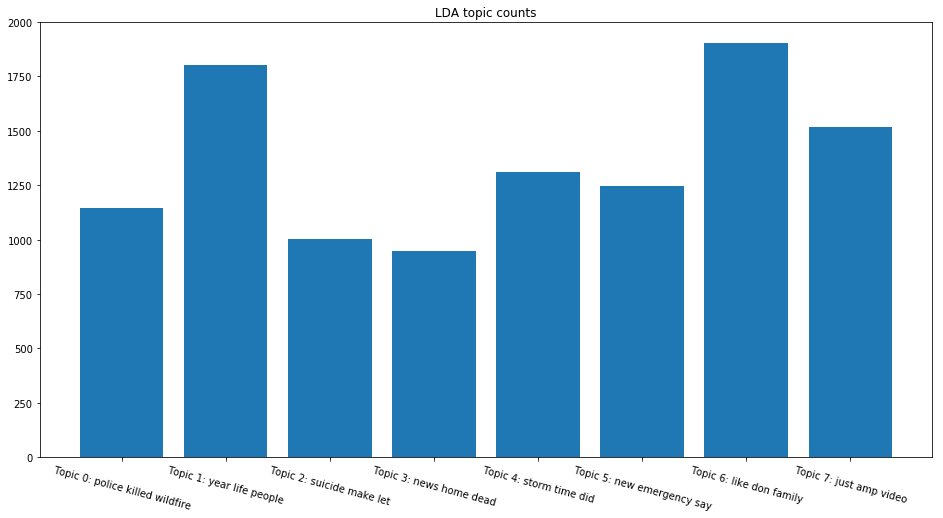

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels, rotation=-15)
ax.set_title('LDA topic counts')

In [31]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [32]:
# t-SNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=42, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10876 samples in 0.055s...
[t-SNE] Computed neighbors for 10876 samples in 2.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10876
[t-SNE] Computed conditional probabilities for sample 2000 / 10876
[t-SNE] Computed conditional probabilities for sample 3000 / 10876
[t-SNE] Computed conditional probabilities for sample 4000 / 10876
[t-SNE] Computed conditional probabilities for sample 5000 / 10876
[t-SNE] Computed conditional probabilities for sample 6000 / 10876
[t-SNE] Computed conditional probabilities for sample 7000 / 10876
[t-SNE] Computed conditional probabilities for sample 8000 / 10876
[t-SNE] Computed conditional probabilities for sample 9000 / 10876
[t-SNE] Computed conditional probabilities for sample 10000 / 10876
[t-SNE] Computed conditional probabilities for sample 10876 / 10876
[t-SNE] Mean sigma: 0.059861
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.601791
[t-SNE] KL

In [33]:
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

In [37]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [43]:
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=' '.join(top_3_words[t]), text_color=colormap[t])
    plot.add_layout(label)

show(plot)